<a href="https://colab.research.google.com/github/zyzhang1992/Quantum-Computing/blob/master/VQE_Matrix_Eigenvalue_QOSF_Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
This note book implements the VQE approach for calculating the lower bounds of a symetrical matrix. 
The matrix is first decomposed in the basis of direct products of Pauli matrices to obtain the 
Hamiltonian for simulation. The decomposition uses the Hilbert-Schmidt-Product approach. 

The implementation includes both simulation on a quantum simulator and actually running on a IBM Q 
quantun device.  
'''

In [ ]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-09-24 17:17:06,081: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

def HS(M1, M2):
    """Hilbert-Schmidt-Product of two matrices M1, M2"""
    return (np.dot(M1.conjugate().transpose(), M2)).trace()

def c2s(c):
    """Return a string representation of a complex number c"""
    if c == 0.0:
        return f"0"
    if c.imag == 0:
        # return "%g" % c.real
        return f"{c.real}"
    elif c.real == 0:
        # return "%gj" % c.imag
        return f"{c.img:g}j"
    else:
        # return "%g+%gj" % (c.real, c.imag)
        return f"{c.real:g}+{c.imag:g}j"

In [ ]:
def decompose(H):
    """Decompose Hermitian 4x4 matrix H into Pauli matrices"""
    from numpy import kron
    sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
    S = [id, sx, sy, sz]
    labels = ['I', 'X', 'Y', 'Z']
    for i in range(4):
        for j in range(4):
            label = labels[i] + labels[j]
            a_ij = 0.25 * HS(kron(S[i], S[j]), H)
            if a_ij != 0.0:
                # print "%s\t*\t(%s)" % (c2s(a_ij), label)
                print (f'{c2s(a_ij)}{label}')

In [ ]:
M = np.array([[1, 0, 0, 0], 
            [0, 0, -1, 0],
            [0, -1, 0, 0],
            [0, 0, 0, 1]], dtype = np. complex128)

In [ ]:
decompose(M)

0.5II
-0.5XX
-0.5YY
0.5ZZ


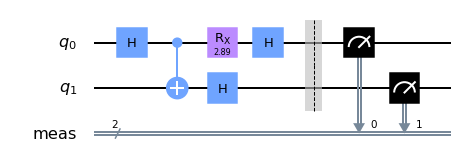

In [ ]:
#
# this tests the construction of quantum circuit for an ansatz for the XX term in the Hamiltonian
#
theta = 2.8903
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.rx(theta, 0)
#
# measurement for XX term
#
qc.h(0)
qc.h(1)
qc.measure_all()

qc.draw()

In [ ]:
def VQE_ansatz(hterm, theta):

    # construct the quantum circuit of the variatinal wave function 
    # for a given variational parameter theta 
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    qc.rx(theta,0)
    # qc.x(1)
    
    if hterm == 1:
        # XX component, the circuit is tranformed to the XX basis first
        qc.h(0)
        qc.h(1)
    elif hterm == 2:
        # YY component, the circuit is tranformed to the YY basis first
        qc.sdg(0)
        qc.h(0)
        qc.sdg(1)
        qc.h(1)
    # for ZZ term (hterm = 3), no transformation is needed. 
    
    # now construct the circuit for measurement in the 0 and 1 qubits
    qc.measure_all()
    
    return qc

In [ ]:
def VQE_energy(qc, backend, nshots):
    result = execute(qc, backend = back_end, shots = nshots).result()
    counts = result.get_counts().items()
    # print(xresult)
    
    result_sum = 0
    for key, count in counts:
        result_sum += (-1) ** (int(key[0]) + int(key[1])) * count
    #print(result_sum)
    
    # return the results normalized with the number of shorts. 
    return result_sum/nshots

The measured counts are: dict_items([('00', 539), ('11', 485)])
The normalized measurement is: 1.0


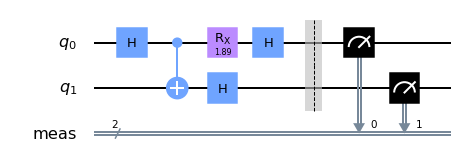

In [ ]:
#
# This tests the execution of measurement of the XX component of the Hamiltonian
#
nshots = 2 ** 10
theta = 1.8903
back_end = Aer.get_backend('qasm_simulator')
# expectation value of XX
xx_qc = VQE_ansatz(hterm = 1, theta = theta)
result = execute(xx_qc, backend = back_end, shots = nshots).result()
counts = result.get_counts().items()
print(f'The measured counts are: {counts}')
    
result_sum = 0
for key, count in counts:
    result_sum += (-1) ** (int(key[0]) + int(key[1])) * count
#print(result_sum)
print(f"The normalized measurement is: {result_sum/nshots}")
xx_qc.draw()

The normalized measurement is: 1.0


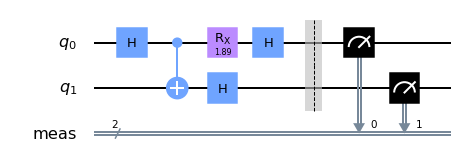

In [ ]:
#
# This tests the VQE_ansatz and VQE_energy functions
#
theta = 1.8903
back_end = Aer.get_backend('qasm_simulator')
nshots = 2 ** 10
# expectation value of XX
xx_qc = VQE_ansatz(hterm = 1, theta = theta)
result = VQE_energy(qc = xx_qc, backend = back_end, nshots = nshots)

print(f"The normalized measurement is: {result}")
xx_qc.draw()

In [ ]:
# The rotational angle will be scanned from 0 to Pi, with a step size of Pi/nsteps. 
# at each step, a quantum circuit of 2 qubits and 2 classcial bits are formed and 

nsteps = 100     #
nshots = 2 ** 10 # the number of shots used in the mesaurement of the quantum circuit.  
back_end = Aer.get_backend('qasm_simulator') # get the device backend, Use the simulator

'''
The Hamiltonian for the simulation is obtained by decomposing the matrix to the basis formed by the 
direct products of the single qubit Pauli matricies X Y Z and I, as shown previously: 
    
M = (1/2)*(-XX - YY + ZZ + II)

To use VQE to obtain the eigen values, a parameterized ansatz is first contructed with the operation 
of h(0), Cx(0,1), and Rx(theta) on the initial qubit function of |00>: (Rx(theta)I)(Cx(0,1))(h(0)I)|00>. 
The expectation values for the three terms XX, YY, ZZ are computed by measurement of the operators in the 
computational basis. X and Y is tranformed to the computational basis with h and sdg respectively. 
The function VQE_ansatz construct the measurement circuit for each of the three operators and VQE_enegy 
actually execute the circuit, either on a simulator or a real quamtumn device at IBM Q, to onbtaint the 
output. 
    
'''

E   = np.zeros(nsteps)
Exx = np.zeros(nsteps)
Eyy = np.zeros(nsteps)
Ezz = np.zeros(nsteps)
Theta = np.zeros(nsteps)
# nsteps = 4
for i in range(nsteps):
    
    theta = (2 * np.pi / nsteps) * (i + 1)
    Theta[i] = theta
    
    xx_qc = VQE_ansatz(hterm = 1, theta = theta)
    Exx[i] = VQE_energy(qc = xx_qc, backend = back_end, nshots=nshots)
    
    yy_qc = VQE_ansatz(hterm = 2, theta = theta)
    Eyy[i] = VQE_energy(qc = yy_qc, backend = back_end, nshots=nshots)
    
    zz_qc = VQE_ansatz(hterm = 3, theta = theta)
    Ezz[i] = VQE_energy(qc = zz_qc, backend = back_end, nshots=nshots)
    
E = (-Exx - Eyy + Ezz + 1)

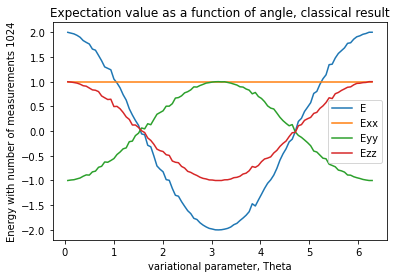

The lower bound to the eigenvalue is -2.0000 at a rotational angle of 3.1416


In [ ]:
plt.title('Expectation value as a function of angle, classical result')
plt.ylabel(f'Energy with number of measurements {nshots}')
plt.xlabel('variational parameter, Theta')
plt.plot(Theta,E,   label=f'E')
plt.plot(Theta,Exx, label=f'Exx')
plt.plot(Theta,Eyy, label=f'Eyy')
plt.plot(Theta,Ezz, label=f'Ezz')
plt.legend()
plt.show()

print(f'The lower bound to the eigenvalue is {min(E):.4f} '
      f'at a rotational angle of {Theta[np.argmin(E)]:.4f}')

In [ ]:
#
# Choose an IBM Q provider device 
#
# IBMQ.providers()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [ ]:
available_devices = provider.backends(filters=lambda x: x.configuration().n_qubits >= 2
                                    and not x.configuration().simulator
                                    and x.status().operational==True)
available_devices

[<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [ ]:
from qiskit.providers.ibmq import least_busy
backend = least_busy(available_devices)

<IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>

In [ ]:
backend.name()

'ibmq_16_melbourne'

In [ ]:
#
# simulations on IBM Q quantum computers
#
try: 
    # back_end = provider.get_backend('ibmq_16_melbourne') #'ibmq_16_melbourne')#'ibmq_essex')
    # back_end = provider.get_backend('ibmq_london') #'ibmq_16_melbourne')#'ibmq_essex')
    back_end = provider.get_backend(backend.name())
except:
    # backend = Aer.get_backend('qasm_simulator') # it was 'BasicAer.get_backend' ibmq_16_melbourne
    print("back end not available")
    
coupling_map = back_end.configuration().coupling_map
print(coupling_map)

[[0, 1], [0, 14], [1, 0], [1, 2], [1, 13], [2, 1], [2, 3], [2, 12], [3, 2], [3, 4], [3, 11], [4, 3], [4, 5], [4, 10], [5, 4], [5, 6], [5, 9], [6, 5], [6, 8], [7, 8], [8, 6], [8, 7], [8, 9], [9, 5], [9, 8], [9, 10], [10, 4], [10, 9], [10, 11], [11, 3], [11, 10], [11, 12], [12, 2], [12, 11], [12, 13], [13, 1], [13, 12], [13, 14], [14, 0], [14, 13]]


In [ ]:
back_end.configuration()

In [ ]:
#
# results from running on the quantum devices at IBM
#

nsteps = 100     #
# nshots = 25
nshots = 2 ** 10 # the number of shots used in the mesaurement of the quantum circuit.  
#back_end = Aer.get_backend('qasm_simulator') # get the device backend, Use the simulator

'''
The hamiltonian for the problem that corresponds 
to our matrix M:
    
M = (1/2)*(XX+YY+ZZ-II)
    
The hamiltonian is computed by separating it into three components
according to the discussions in the previous cells. 
'''

E = np.zeros(nsteps)
Exx = np.zeros(nsteps)
Eyy = np.zeros(nsteps)
Ezz = np.zeros(nsteps)
Theta = np.zeros(nsteps)
for i in range(nsteps):
    
    theta = (2 * np.pi / nsteps) * (i + 1)
    Theta[i] = theta
    
    xx_qc = VQE_ansatz(hterm = 1, theta = theta)
    Exx[i] = VQE_energy(qc = xx_qc, backend = back_end, nshots=nshots)
    
    yy_qc = VQE_ansatz(hterm = 2, theta = theta)
    Eyy[i] = VQE_energy(qc = yy_qc, backend = back_end, nshots=nshots)
    
    zz_qc = VQE_ansatz(hterm = 3, theta = theta)
    Ezz[i] = VQE_energy(qc = zz_qc, backend = back_end, nshots=nshots)

In [ ]:
E = 1/2 * (-Exx - Eyy + Ezz + 1)

In [ ]:
plt.title(f'Expectation value as a function of angle, quamtum result')
plt.ylabel(f'Energy with number of measurements {nshots}')
plt.xlabel(f'variational parameter, Theta')
plt.plot(Theta,E,   label=f'E')
plt.plot(Theta,Exx, label=f'Exx')
plt.plot(Theta,Eyy, label=f'Eyy')
plt.plot(Theta,Ezz, label=f'Ezz')
plt.legend()
plt.show()

print(f'The lower bound to the eigenvalue is {min(E):.4f} '
      f'at a rotational angle of {Theta[np.argmin(E)]:.4f}')